# Hyperparameter Tuning

First result with Parameters: {'learning_rate': Real(low=0.005, high=0.1, prior='log-uniform', transform='identity'), 'max_iter': Integer(low=100, high=1500, prior='uniform', transform='identity'), 'max_depth': Integer(low=3, high=15, prior='uniform', transform='identity'), 'min_samples_leaf': Integer(low=10, high=50, prior='uniform', transform='identity'), 'l2_regularization': Real(low=0.0001, high=0.1, prior='log-uniform', transform='identity'), 'n_iter_no_change': Integer(low=10, high=30, prior='uniform', transform='identity')}

Result: OrderedDict({'l2_regularization': 0.0001, 'learning_rate': 0.1, 'max_depth': 11, 'max_iter': 1500, 'min_samples_leaf': 10, 'n_iter_no_change': 22})

RMSE: 1.5422279327391433
R2 Score: 0.7584204840617608

Next iteration trying to prevent overfitting:

``` json
search_space = {
    'learning_rate': Real(0.005, 0.1, prior='log-uniform'),
    'max_iter': Integer(100, 1500),
    'max_depth': Integer(6, 12),
    'min_samples_leaf': Integer(10, 20),
    'max_leaf_nodes': Integer(20, 50),
    'l2_regularization': Real(1e-5, 1e-3, prior='log-uniform'),
    'n_iter_no_change': Integer(10, 30),
}
```


In [1]:
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor

from data import load_data_selected_features
from pipelines_selected_features import pipeline

train_data, additional_train_data, test_data = load_data_selected_features()
all_train_data = pipeline.fit_transform(pd.concat([train_data, additional_train_data]))

# cut the data into train, additional train and test
train_data = all_train_data.loc[train_data.index]
additional_train_data = all_train_data.loc[additional_train_data.index]

X_train = train_data.drop(columns=['bg+1:00'])
y_train = train_data['bg+1:00']

X_additional_train = additional_train_data.drop(columns=['bg+1:00'])
y_additional_train = additional_train_data['bg+1:00']

### Tune HistGradientBoostingRegressor

#### Stage 1: Tune learning_rate and l2_regularization
search_space_stage1 = {
    'learning_rate': Real(0.005, 0.1, prior='log-uniform'),
    'l2_regularization': Real(1e-5, 1e-1, prior='log-uniform'),
}

#### Stage 2: Tune max_iter and max_depth based on Stage 1 results
search_space_stage2 = {
    'max_iter': Integer(100, 3000),
    'max_depth': Integer(3, 20),
    'min_samples_leaf': Integer(5, 100),
}


11:54:25 - Start tuning HistGradientBoostingRegressor
11:54:25 - Parameters: {'learning_rate': Real(low=0.005, high=0.3, prior='log-uniform', transform='identity'), 'max_iter': Integer(low=100, high=1500, prior='uniform', transform='identity'), 'max_depth': Integer(low=6, high=8, prior='uniform', transform='identity'), 'min_samples_leaf': Integer(low=15, high=30, prior='uniform', transform='identity'), 'max_leaf_nodes': Integer(low=10, high=30, prior='uniform', transform='identity'), 'l2_regularization': Real(low=0.0001, high=0.01, prior='log-uniform', transform='identity'), 'n_iter_no_change': Integer(low=10, high=15, prior='uniform', transform='identity'), 'validation_fraction': Real(low=0.1, high=0.3, prior='uniform', transform='identity')}
11:54:25 - Fitting the model
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/Users/ralf/Projects/learning-projects/datascience-bootcamp/sep24_bds_int_medical/notebooks/ralf/modelling/3.30-global-model-bg-insulin-cals-hr-steps-1hs-5min/model_hyperparameter_tuning.py:55: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y_all_train = pd.concat([y_train, y_additional_train])


Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fits
Fitting 2 folds for each of 1 candidates, totalling 2 fi

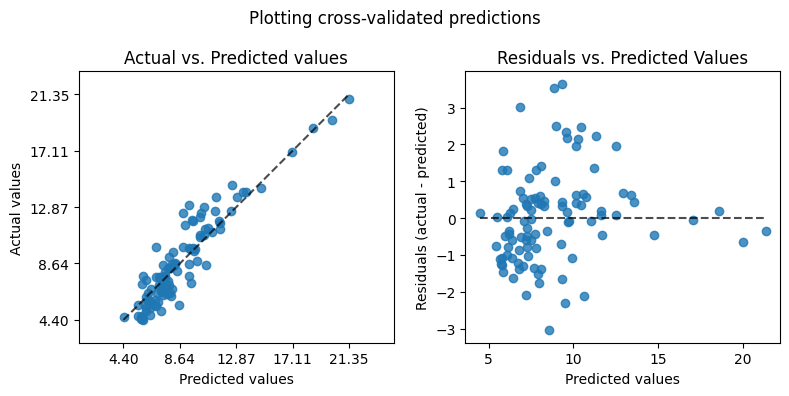

In [2]:
from skopt.space import Real, Integer
from model_hyperparameter_tuning import tune_hyperparameters

search_space = {
    'learning_rate': Real(0.005, 0.3, prior='log-uniform'),
    'max_iter': Integer(100, 1500),
    'max_depth': Integer(6, 8),
    'min_samples_leaf': Integer(15, 30),
    'max_leaf_nodes': Integer(10, 30),
    'l2_regularization': Real(1e-4, 1e-2, prior='log-uniform'),
    'n_iter_no_change': Integer(10, 15),
    'validation_fraction': Real(0.1, 0.3),
}

model = HistGradientBoostingRegressor(scoring='neg_mean_squared_error', random_state=42, max_bins=255)
best_estimator, best_params = tune_hyperparameters(model, search_space, pd.DataFrame(), pd.Series(), X_additional_train, y_additional_train, num_iter=50, n_splits=2)

In [3]:
import os
import joblib

best_estimator_file_name = f'{model.__class__.__name__}.best_estimator.pkl'
joblib.dump(best_estimator, os.path.join('models', best_estimator_file_name))

['models/HistGradientBoostingRegressor.best_estimator.pkl']